In [191]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
import pandas as pd

from skimage.feature import hog
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from skimage.transform import resize

from tqdm import tqdm
from collections import defaultdict
from skimage.filters import unsharp_mask

%matplotlib inline
pp = pprint.PrettyPrinter(indent=4)

import Augmentor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

### Divide the dataset in train and test in relation 4 to 1

In [ ]:
import os
import shutil

folder_path = 'Images'

folders = [ 'Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

for folder in folders:                         # cicle on the illness' stages
    path = os.path.join(folder_path, folder)
    files = os.listdir(path)
    for num, file in enumerate(files):         # cicle on the images
      file_path = os.path.join(path, file)

      if file.endswith('.jpg') or file.endswith('.png'):
          if num < 0.80*(len(files)):          # take the first 80 percent as train set
            new_path = os.path.join(path, 'train')
            shutil.copy(file_path,new_path)
          else:                                # take the rest as test set
            new_path = os.path.join(path, 'test')
            shutil.copy(file_path,new_path)

### Import the images, cropping and applying sharpening filter

In [2]:
def read_images(paths):
    counter = 1
    new_data = defaultdict(list)
    for path in paths:                                    # cicle on the folders, i.e. on the different stages
        for image in tqdm(os.listdir(path)):
            if image[-3:] == 'jpg':
                mri = imread(os.path.join(path, image))   # read the image
                mri = mri[11:117,11:117]                  # crop the image removing the black around
                mri = resize(mri, (128,128))              # resize to (128,128) pixels, to improve HOG results
                mri = unsharp_mask(mri)                   # apply sharpening filter
                new_data[counter].append(mri)
        counter += 1
    return new_data

In [3]:
paths_Train = [ 'Images\\Non_Demented\\train','Images\\Very_Mild_Demented\\train','Images\\Mild_Demented\\train','Images\\Moderate_Demented\\train']

data_train = read_images(paths_Train)

100%|██████████| 54/54 [00:00<00:00, 236.82it/s]


In [4]:
paths_Test = [ 'Images\\Non_Demented\\test','Images\\Very_Mild_Demented\\test','Images\\Mild_Demented\\test','Images\\Moderate_Demented\\test']

data_test = read_images(paths_Test)

100%|██████████| 11/11 [00:00<00:00, 210.21it/s]


### Calculate the histogram of the gradients with different parameters

In [5]:
def hog_apply(data_train, data_test, ppc, cpb, norm):
    
    data_train_hog = defaultdict(list)   
    data_test_hog = defaultdict(list) 
    # apply HOG function on the images and store them in a dict, for both train and set
    for img_train in tqdm(data_train.keys()):
        data_train_hog[img_train]=list(map(lambda l: hog(l, pixels_per_cell=ppc, cells_per_block=cpb, block_norm=norm), data_train[img_train]))
    
    for img_test in tqdm(data_test.keys()):
        data_test_hog[img_test]=list(map(lambda l: hog(l, pixels_per_cell=ppc, cells_per_block=cpb, block_norm=norm), data_test[img_test]))
    
    return data_train_hog, data_test_hog

We have to prove different parameters to check which is the best for the $\textbf{HOG}$ function. We have proved:

***

| pixels per cell | cells per box | norm |
|---|---|---|
| (8,8) | (2,2) | 'L1' |
| (16,16) |  (2,2) | 'L1-sqrt' |
| (8,8) | (4,4) | 'L2' |
| (16,16) | (4,4) | 'L2-Hys' |
| (8,8) | (2,2) | 'L1-sqrt' |
| (16,16) | (2,2) | 'L2' |
| (8,8) | (4,4) | 'L2-Hys' |
| (16,16) | (4,4) | 'L1' |
| (8,8) | (2,2) | 'L2' |
| (16,16) | (2,2) | 'L2-Hys' |
| (8,8) | (4,4) | 'L1' |
| (16,16) | (4,4) | 'L1-sqrt' |
| (8,8) | (2,2) | 'L2-Hys' |
| (16,16) | (2,2) | 'L1' |
| (8,8) | (4,4) | 'L1-sqrt' |
| (16,16) | (4,4) | 'L2' |

***


In [99]:
hog_train1, hog_test1 = hog_apply(data_train, data_test, (8,8), (2,2), 'L1')

100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


In [7]:
hog_train2, hog_test2 = hog_apply(data_train, data_test, (8,8), (4,4), 'L1')

100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


In [8]:
hog_train3, hog_test3 = hog_apply(data_train, data_test, (16,16), (2,2), 'L1')

100%|██████████| 4/4 [00:02<00:00,  1.35it/s]


In [9]:
hog_train4, hog_test4 = hog_apply(data_train, data_test, (16,16), (4,4), 'L1')

100%|██████████| 4/4 [00:03<00:00,  1.33it/s]


In [10]:
hog_train5, hog_test5 = hog_apply(data_train, data_test, (8,8), (2,2), 'L1-sqrt')

100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


In [11]:
hog_train6, hog_test6 = hog_apply(data_train, data_test, (8,8), (4,4), 'L1-sqrt')

100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


In [12]:
hog_train7, hog_test7 = hog_apply(data_train, data_test, (16,16), (2,2), 'L1-sqrt')

100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


In [13]:
hog_train8, hog_test8 = hog_apply(data_train, data_test, (16,16), (4,4), 'L1-sqrt')

100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


In [14]:
hog_train9, hog_test9 = hog_apply(data_train, data_test, (8,8), (2,2), 'L2')

100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


In [15]:
hog_train10, hog_test10 = hog_apply(data_train, data_test, (8,8), (4,4), 'L2')

100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


In [16]:
hog_train11, hog_test11 = hog_apply(data_train, data_test, (16,16), (2,2), 'L2')

100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


In [17]:
hog_train12, hog_test12 = hog_apply(data_train, data_test, (16,16), (4,4), 'L2')

100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


In [18]:
hog_train13, hog_test13 = hog_apply(data_train, data_test, (8,8), (2,2), 'L2-Hys')

100%|██████████| 4/4 [00:06<00:00,  1.75s/it]


In [61]:
hog_train14, hog_test14 = hog_apply(data_train, data_test, (8,8), (4,4), 'L2-Hys')

100%|██████████| 4/4 [00:08<00:00,  2.24s/it]


In [20]:
hog_train15, hog_test15 = hog_apply(data_train, data_test, (16,16), (2,2), 'L2-Hys')

100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


In [21]:
hog_train16, hog_test16 = hog_apply(data_train, data_test, (16,16), (4,4), 'L2-Hys')

100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


## Example of MRI

In [156]:
def plotta(list_images, size1=8, size2=6):  # function to plot MRI
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(size1, size2)
    [a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) for a in ax]
    for i in range(len(list_images)):
        img = list_images[i]
        ax[i].imshow(img, cmap='gray')
    plt.show()

In [157]:
hog_non_dem = hog(data_train[1][0], pixels_per_cell=(8,8), cells_per_block=(4,4), block_norm='L2-Hys', visualize=True)[1]

Example of non demented's MRI and relative HOG


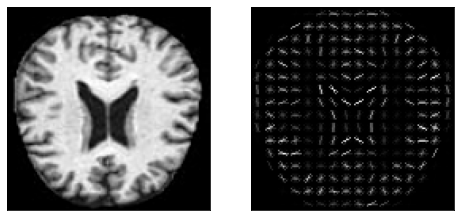

In [158]:
print("Example of non demented's MRI and relative HOG")
images = [data_train[1][0], hog_non_dem]
plotta(images)

In [159]:
hog_very = hog(data_train[2][0], pixels_per_cell=(8,8), cells_per_block=(4,4), block_norm='L2-Hys', visualize=True)[1]

Example of very mild demented's MRI and relative HOG


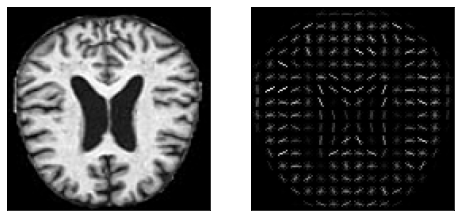

In [160]:
print("Example of very mild demented's MRI and relative HOG")
images = [data_train[2][0], hog_very]
plotta(images)

In [161]:
hog_mild = hog(data_train[3][0], pixels_per_cell=(8,8), cells_per_block=(4,4), block_norm='L2-Hys', visualize=True)[1]

Example of mild demented's MRI and relative HOG


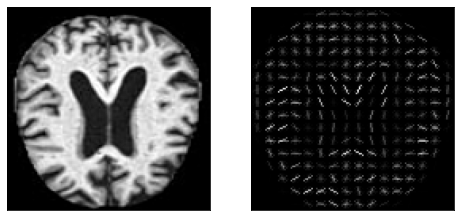

In [162]:
print("Example of mild demented's MRI and relative HOG")
images = [data_train[3][0], hog_mild]
plotta(images)

In [163]:
hog_mod = hog(data_train[4][0], pixels_per_cell=(8,8), cells_per_block=(4,4), block_norm='L2-Hys', visualize=True)[1]

Example of moderate demented's MRI and relative HOG


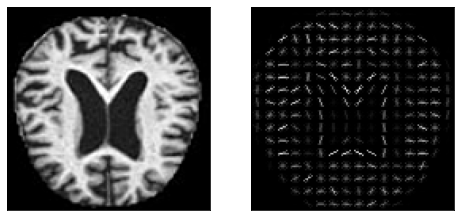

In [164]:
print("Example of moderate demented's MRI and relative HOG")
images = [data_train[4][0], hog_mod]
plotta(images)

### Keep the list of labels 

In [8]:
def create_labels(labels, times_per_labels):
    return np.concatenate([np.repeat(labels[0], times_per_labels[0]), np.repeat(labels[1], times_per_labels[1]),
                           np.repeat(labels[2], times_per_labels[2]), np.repeat(labels[3], times_per_labels[3])])

In [62]:
labels_list = [ 'Non demented', 'Very mild', 'Mild', 'Moderate']
rep_times = [2562, 1792, 719, 53]
labels = create_labels(labels_list, rep_times)

rep_times_test = [638, 448, 177, 11]
labels_test = create_labels(labels_list, rep_times_test)

### Apply MinMaxScaler 

In [11]:
scalify = MinMaxScaler()

### Fit our train set with SGDClassifier (loss = logistic regrassion)

In [26]:
X_train1 = np.vstack((hog_train1[1],hog_train1[2],hog_train1[3],hog_train1[4]))
X_train_prepared1 = scalify.fit_transform(X_train1)
sgd_clf1 = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf1.fit(X_train_prepared1, labels)

SGDClassifier(random_state=42)

In [27]:
X_train2 = np.vstack((hog_train2[1],hog_train2[2],hog_train2[3],hog_train2[4]))
X_train_prepared2 = scalify.fit_transform(X_train2)
sgd_clf2 = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf2.fit(X_train_prepared2, labels)

SGDClassifier(random_state=42)

In [28]:
X_train3 = np.vstack((hog_train3[1],hog_train3[2],hog_train3[3],hog_train3[4]))
X_train_prepared3 = scalify.fit_transform(X_train3)
sgd_clf3 = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf3.fit(X_train_prepared3, labels)

SGDClassifier(random_state=42)

In [29]:
X_train4= np.vstack((hog_train4[1],hog_train4[2],hog_train4[3],hog_train4[4]))
X_train_prepared4 = scalify.fit_transform(X_train4)
sgd_clf4 = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf4.fit(X_train_prepared4, labels)

SGDClassifier(random_state=42)

In [30]:
X_train5= np.vstack((hog_train5[1],hog_train5[2],hog_train5[3],hog_train5[4]))
X_train_prepared5 = scalify.fit_transform(X_train5)
sgd_clf5 = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf5.fit(X_train_prepared5, labels)

SGDClassifier(random_state=42)

In [31]:
X_train6= np.vstack((hog_train6[1],hog_train6[2],hog_train6[3],hog_train6[4]))
X_train_prepared6 = scalify.fit_transform(X_train6)
sgd_clf6 = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf6.fit(X_train_prepared6, labels)

SGDClassifier(random_state=42)

In [32]:
X_train7= np.vstack((hog_train7[1],hog_train7[2],hog_train7[3],hog_train7[4]))
X_train_prepared7 = scalify.fit_transform(X_train7)
sgd_clf7 = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf7.fit(X_train_prepared7, labels)

SGDClassifier(random_state=42)

In [33]:
X_train8= np.vstack((hog_train8[1],hog_train8[2],hog_train8[3],hog_train8[4]))
X_train_prepared8 = scalify.fit_transform(X_train8)
sgd_clf8 = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf8.fit(X_train_prepared8, labels)

SGDClassifier(random_state=42)

In [34]:
X_train9= np.vstack((hog_train9[1],hog_train9[2],hog_train9[3],hog_train9[4]))
X_train_prepared9 = scalify.fit_transform(X_train9)
sgd_clf9 = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf9.fit(X_train_prepared9, labels)

SGDClassifier(random_state=42)

In [35]:
X_train10= np.vstack((hog_train10[1],hog_train10[2],hog_train10[3],hog_train10[4]))
X_train_prepared10 = scalify.fit_transform(X_train10)
sgd_clf10 = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf10.fit(X_train_prepared10, labels)

SGDClassifier(random_state=42)

In [36]:
X_train11= np.vstack((hog_train11[1],hog_train11[2],hog_train11[3],hog_train11[4]))
X_train_prepared11 = scalify.fit_transform(X_train11)
sgd_clf11 = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf11.fit(X_train_prepared11, labels)

SGDClassifier(random_state=42)

In [37]:
X_train12= np.vstack((hog_train12[1],hog_train12[2],hog_train12[3],hog_train12[4]))
X_train_prepared12 = scalify.fit_transform(X_train12)
sgd_clf12 = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf12.fit(X_train_prepared12, labels)

SGDClassifier(random_state=42)

In [38]:
X_train13= np.vstack((hog_train13[1],hog_train13[2],hog_train13[3],hog_train13[4]))
X_train_prepared13 = scalify.fit_transform(X_train13)
sgd_clf13 = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf13.fit(X_train_prepared13, labels)

SGDClassifier(random_state=42)

In [ ]:
X_train14= np.vstack((hog_train14[1],hog_train14[2],hog_train14[3],hog_train14[4]))
X_train_prepared14 = scalify.fit_transform(X_train14)
sgd_clf14 = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf14.fit(X_train_prepared14, labels)

In [40]:
X_train15= np.vstack((hog_train15[1],hog_train15[2],hog_train15[3],hog_train15[4]))
X_train_prepared15 = scalify.fit_transform(X_train15)
sgd_clf15 = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf15.fit(X_train_prepared15, labels)

SGDClassifier(random_state=42)

In [41]:
X_train16= np.vstack((hog_train16[1],hog_train16[2],hog_train16[3],hog_train16[4]))
X_train_prepared16 = scalify.fit_transform(X_train16)
sgd_clf16 = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf16.fit(X_train_prepared16, labels)

SGDClassifier(random_state=42)

#### Apply MinMaxScaler to the test set and finally predict the labels.

In [42]:
X_test1=np.vstack((hog_test1[1], hog_test1[2], hog_test1[3], hog_test1[4]))
X_test_prepared1 = scalify.fit_transform(X_test1)
y_pred1 = sgd_clf1.predict(X_test_prepared1)

In [43]:
X_test2=np.vstack((hog_test2[1], hog_test2[2], hog_test2[3], hog_test2[4]))
X_test_prepared2 = scalify.fit_transform(X_test2)
y_pred2 = sgd_clf2.predict(X_test_prepared2)

In [44]:
X_test3=np.vstack((hog_test3[1], hog_test3[2], hog_test3[3], hog_test3[4]))
X_test_prepared3 = scalify.fit_transform(X_test3)
y_pred3 = sgd_clf3.predict(X_test_prepared3)

In [45]:
X_test4=np.vstack((hog_test4[1], hog_test4[2], hog_test4[3], hog_test4[4]))
X_test_prepared4 = scalify.fit_transform(X_test4)
y_pred4 = sgd_clf4.predict(X_test_prepared4)

In [46]:
X_test5=np.vstack((hog_test5[1], hog_test5[2], hog_test5[3], hog_test5[4]))
X_test_prepared5 = scalify.fit_transform(X_test5)
y_pred5 = sgd_clf5.predict(X_test_prepared5)

In [47]:
X_test6=np.vstack((hog_test6[1], hog_test6[2], hog_test6[3], hog_test6[4]))
X_test_prepared6 = scalify.fit_transform(X_test6)
y_pred6 = sgd_clf6.predict(X_test_prepared6)

In [48]:
X_test7=np.vstack((hog_test7[1], hog_test7[2], hog_test7[3], hog_test7[4]))
X_test_prepared7 = scalify.fit_transform(X_test7)
y_pred7 = sgd_clf7.predict(X_test_prepared7)

In [49]:
X_test8=np.vstack((hog_test8[1], hog_test8[2], hog_test8[3], hog_test8[4]))
X_test_prepared8 = scalify.fit_transform(X_test8)
y_pred8 = sgd_clf8.predict(X_test_prepared8)

In [50]:
X_test9=np.vstack((hog_test9[1], hog_test9[2], hog_test9[3], hog_test9[4]))
X_test_prepared9 = scalify.fit_transform(X_test9)
y_pred9 = sgd_clf9.predict(X_test_prepared9)

In [51]:
X_test10=np.vstack((hog_test10[1], hog_test10[2], hog_test10[3], hog_test10[4]))
X_test_prepared10 = scalify.fit_transform(X_test10)
y_pred10 = sgd_clf10.predict(X_test_prepared10)

In [52]:
X_test11=np.vstack((hog_test11[1], hog_test11[2], hog_test11[3], hog_test11[4]))
X_test_prepared11 = scalify.fit_transform(X_test11)
y_pred11 = sgd_clf11.predict(X_test_prepared11)

In [53]:
X_test12=np.vstack((hog_test12[1], hog_test12[2], hog_test12[3], hog_test12[4]))
X_test_prepared12 = scalify.fit_transform(X_test12)
y_pred12 = sgd_clf12.predict(X_test_prepared12)

In [54]:
X_test13=np.vstack((hog_test13[1], hog_test13[2], hog_test13[3], hog_test13[4]))
X_test_prepared13 = scalify.fit_transform(X_test13)
y_pred13 = sgd_clf13.predict(X_test_prepared13)

In [64]:
X_test14=np.vstack((hog_test14[1], hog_test14[2], hog_test14[3], hog_test14[4]))
X_test_prepared14 = scalify.fit_transform(X_test14)
y_pred14 = sgd_clf14.predict(X_test_prepared14)

In [56]:
X_test15=np.vstack((hog_test15[1], hog_test15[2], hog_test15[3], hog_test15[4]))
X_test_prepared15 = scalify.fit_transform(X_test15)
y_pred15 = sgd_clf15.predict(X_test_prepared15)

In [57]:
X_test16=np.vstack((hog_test16[1], hog_test16[2], hog_test16[3], hog_test16[4]))
X_test_prepared16 = scalify.fit_transform(X_test16)
y_pred16 = sgd_clf16.predict(X_test_prepared16)

#### Let's evaluate the performance of the model

In [58]:
print(np.array(y_pred1 == labels_test)[:20])
print('Percentage correct: ', 100*np.sum(y_pred1 == labels_test)/len(labels_test))

[ True  True  True  True  True  True False  True  True False  True  True
  True  True  True  True  True  True  True  True]
Percentage correct:  64.36420722135009


In [59]:
print(np.array(y_pred2 == labels_test)[:20])
print('Percentage correct: ', 100*np.sum(y_pred2 == labels_test)/len(labels_test))

[ True  True  True  True  True  True False  True  True False  True  True
  True  True  True  True  True  True False  True]
Percentage correct:  66.56200941915228


In [60]:
print(np.array(y_pred3 == labels_test)[:20])
print('Percentage correct: ', 100*np.sum(y_pred3 == labels_test)/len(labels_test))

[ True False  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Percentage correct:  62.009419152276294


In [61]:
print(np.array(y_pred4 == labels_test)[:20])
print('Percentage correct: ', 100*np.sum(y_pred4 == labels_test)/len(labels_test))

[ True False  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Percentage correct:  61.30298273155416


In [62]:
print(np.array(y_pred5 == labels_test)[:20])
print('Percentage correct: ', 100*np.sum(y_pred5 == labels_test)/len(labels_test))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Percentage correct:  63.42229199372056


In [63]:
print(np.array(y_pred6 == labels_test)[:20])
print('Percentage correct: ', 100*np.sum(y_pred6 == labels_test)/len(labels_test))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Percentage correct:  67.58241758241758


In [64]:
print(np.array(y_pred7 == labels_test)[:20])
print('Percentage correct: ', 100*np.sum(y_pred7 == labels_test)/len(labels_test))

[ True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Percentage correct:  59.26216640502355


In [65]:
print(np.array(y_pred8 == labels_test)[:20])
print('Percentage correct: ', 100*np.sum(y_pred8 == labels_test)/len(labels_test))

[ True False  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Percentage correct:  59.10518053375196


In [66]:
print(np.array(y_pred9 == labels_test)[:20])
print('Percentage correct: ', 100*np.sum(y_pred9 == labels_test)/len(labels_test))

[ True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True]
Percentage correct:  68.5243328100471


In [67]:
print(np.array(y_pred10 == labels_test)[:20])
print('Percentage correct: ', 100*np.sum(y_pred10 == labels_test)/len(labels_test))

[ True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True False  True]
Percentage correct:  68.91679748822607


In [68]:
print(np.array(y_pred11 == labels_test)[:20])
print('Percentage correct: ', 100*np.sum(y_pred11 == labels_test)/len(labels_test))

[ True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Percentage correct:  58.712715855572995


In [69]:
print(np.array(y_pred12 == labels_test)[:20])
print('Percentage correct: ', 100*np.sum(y_pred12 == labels_test)/len(labels_test))

[ True False  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Percentage correct:  57.927786499215074


In [70]:
print(np.array(y_pred13 == labels_test)[:20])
print('Percentage correct: ', 100*np.sum(y_pred13 == labels_test)/len(labels_test))

[ True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Percentage correct:  66.3265306122449


In [71]:
print(np.array(y_pred14 == labels_test)[:20])
print('Percentage correct: ', 100*np.sum(y_pred14 == labels_test)/len(labels_test))

[ True False  True  True  True  True False  True  True False  True  True
  True  True  True  True  True  True  True  True]
Percentage correct:  70.48665620094191


In [72]:
print(np.array(y_pred15 == labels_test)[:20])
print('Percentage correct: ', 100*np.sum(y_pred15 == labels_test)/len(labels_test))

[ True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True]
Percentage correct:  60.75353218210361


In [73]:
print(np.array(y_pred16 == labels_test)[:20])
print('Percentage correct: ', 100*np.sum(y_pred16 == labels_test)/len(labels_test))

[ True False  True  True  True  True False  True  True  True  True  True
  True False False  True  True False False  True]
Percentage correct:  49.45054945054945


We obtain the best result with the parameters:

* pixels per cell = (8,8);
* cells per block = (4,4);
* norm = 'L2-Hys'.

From now on we will use these parameters for the next tests.

### Find with GridSearch the best parameters

Once we have found the suitable parameters for the HOG let's try some models to fit our data.
GridSearch could be usefull for that: with this tool we have proved the SVM and the logistic regression modell,
with several parameters. 

Furthermore we use StratifiedKFold as cross validator.

In [67]:
# create the model
model = SGDClassifier(random_state=42)

# define the parameter grid
param_grid = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge'],
    'penalty': ['l1', 'l2'],
    'alpha': [0.001, 0.01],
    'tol': [0.0001, 0.001],
    'max_iter': [1000]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# create the grid search object
grid = GridSearchCV(model, param_grid, cv=skf, scoring='accuracy', n_jobs=-1)

# fit the grid search to the data
grid.fit(X_train_prepared, labels_train)

# print the best parameters
print(grid.best_params_)

{'alpha': 0.001,
 'loss': 'log_loss',
 'max_iter': 1000,
 'penalty': 'l2',
 'tol': 0.001}

The GridSearch gives as result that the best model to use is the logistic regression.

### Augmented dataset

Now that we have chosen the parameters, let's try to oversample the images in the folders less numerous
flipping the retrieved images horizontally. After that we apply the HOG function and the model with the parameters found by the GridSearch.

In [7]:
folders = [ 'Images\\Non_Demented\\train','Images\\Very_Mild_Demented\\train','Images\\Mild_Demented\\train','Images\\Moderate_Demented\\train']

for folder in folders:
    
    new_images = Augmentor.Pipeline(folder)
    new_images.flip_left_right(probability=0.5)


    new_images.sample(2562-len(os.listdir(folder)))

Initialised with 2562 image(s) found.
Output directory set to Images\Non_Demented\train\output.

Executing Pipeline: 0 Samples [00:00, ? Samples/s]


Initialised with 1792 image(s) found.
Output directory set to Images\Very_Mild_Demented\train\output.

Processing <PIL.Image.Image image mode=L size=128x128 at 0x1E005A04640>: 100%|██████████| 769/769 [00:01<00:00, 433.52 Samples/s]                  


Initialised with 719 image(s) found.
Output directory set to Images\Mild_Demented\train\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=L size=128x128 at 0x1E00595ACA0>: 100%|██████████| 1842/1842 [00:03<00:00, 536.82 Samples/s] 


Initialised with 53 image(s) found.
Output directory set to Images\Moderate_Demented\train\output.

Processing <PIL.Image.Image image mode=L size=128x128 at 0x1E006B5FBB0>: 100%|██████████| 2508/2508 [00:04<00:00, 512.93 Samples/s]                  


In [36]:
def read_images_aug(paths):
    counter = 1
    new_data = defaultdict(list)
    for path in paths:
        for image in tqdm(os.listdir(path)):        
            if image[-3:] == 'jpg':
                mri = imread(os.path.join(path, image))
                mri = mri[11:117,11:117]
                mri = resize(mri, (128,128))
                mri = unsharp_mask(mri)
                new_data[counter].append(mri)
                
        # Augmentor put the oversampled images in an other subfolder called 'output'
        for image in tqdm(os.listdir(os.path.join(path, 'output'))):
            if image[-3:] == 'jpg':
                mri = imread(os.path.join(path, 'output', image))
                mri = mri[11:117,11:117]
                mri = resize(mri, (128,128))
                mri = unsharp_mask(mri)
                new_data[counter].append(mri)
        counter += 1
    return new_data

In [37]:
paths_Train = [ 'Images\\Non_Demented\\train','Images\\Very_Mild_Demented\\train','Images\\Mild_Demented\\train','Images\\Moderate_Demented\\train']

data_train_aug = read_images_aug(paths_Train)

100%|██████████| 2563/2563 [00:09<00:00, 276.25it/s]
0it [00:00, ?it/s]
100%|██████████| 2508/2508 [00:08<00:00, 285.03it/s]


In [39]:
hog_train_aug, hog_test_aug = hog_apply(data_train_aug, data_test, (8,8), (4,4), 'L2-Hys')

100%|██████████| 4/4 [00:11<00:00,  2.82s/it]


In [40]:
labels_list = [ 'Non demented', 'Very mild', 'Mild','Moderate']
rep_times = [2562, 2562, 2562, 2562]
labels = create_labels(labels_list, rep_times)

rep_times_test = [638, 448, 177, 11]
labels_test = create_labels(labels_list, rep_times_test)

In [41]:
X_train = np.vstack((hog_train_aug[1],hog_train_aug[2],hog_train_aug[3],hog_train_aug[4]))
X_train_prepared = scalify.fit_transform(X_train)
sgd_clf = SGDClassifier(alpha = 0.001, loss = 'log_loss', max_iter = 1000, penalty = 'l2', tol = 0.001)
sgd_clf.fit(X_train_prepared, labels)

SGDClassifier(alpha=0.001, loss='log_loss')

In [42]:
X_test = np.vstack((hog_test_aug[1], hog_test_aug[2], hog_test_aug[3], hog_test_aug[4]))
X_test_prepared = scalify.fit_transform(X_test)
y_pred = sgd_clf.predict(X_test_prepared)

In [43]:
print(np.array(y_pred == labels_test)[:20])
print('Percentage correct: ', 100*np.sum(y_pred == labels_test)/len(labels_test))

[ True False  True  True  True  True False  True False False  True  True
  True  True  True  True  True False False  True]
Percentage correct:  56.98587127158556


The result obtained with the increased dataset is far worse than the initial one: probably the oversampling 'confuses' our model.

### Grayscalse histogram

Let's try another way: we can use the grayscale histogram to fit our model.

In [30]:
def funz(photo,b): # putting a 'photo', gives an histogram with 'b' bins.
    histo = np.histogram(photo,bins=b,range=(0,1))[0]  
    return histo.T

In [49]:
hog_train, hog_test = hog_apply(data_train, data_test, (8,8), (4,4), 'L2-Hys')
X_train = np.vstack((hog_train[1],hog_train[2],hog_train[3],hog_train[4]))
X_test = np.vstack((hog_test[1], hog_test[2], hog_test[3], hog_test[4]))
X_train_prepared = scalify.fit_transform(X_train)
X_test_prepared = scalify.fit_transform(X_test)

In [60]:
for b in range(10,110,10):            # Fit our model with histograms from 10 to 100 bins
    mattrain=np.zeros((5126,b))
    mattest=np.zeros((1274,b))
    for i,k in enumerate(X_train):
        mattrain[i]=funz(k,b)
    for i,k in enumerate(X_test):
        mattest[i]=funz(k,b)
    
    X_train_prepared = scalify.fit_transform(mattrain)
    X_test_prepared = scalify.fit_transform(mattest)
    
    sgd_clf = SGDClassifier(alpha = 0.001, loss = 'log_loss', max_iter = 1000, penalty = 'l2', tol = 0.001)
    sgd_clf.fit(X_train_prepared, labels)
    y_pred = sgd_clf.predict(X_test_prepared)
    print('Percentage correct for histogram with',b,'bins: ', 100*np.sum(y_pred == labels_test)/len(labels_test))

Percentage correct for histogram with 10 bins:  50.15698587127159
Percentage correct for histogram with 20 bins:  50.313971742543174
Percentage correct for histogram with 30 bins:  41.915227629513346
Percentage correct for histogram with 40 bins:  49.37205651491366
Percentage correct for histogram with 50 bins:  49.13657770800628
Percentage correct for histogram with 60 bins:  49.21507064364207
Percentage correct for histogram with 70 bins:  48.665620094191524
Percentage correct for histogram with 80 bins:  49.058084772370485
Percentage correct for histogram with 90 bins:  48.82260596546311
Percentage correct for histogram with 100 bins:  49.45054945054945


The results are not at all satisfactory. Probably the issue is the method not the number of features use to fit the model, given that the result doesn't improve increasing the number of bins.

Now we can try to merge the previous data obtain by the HOG and by the grayscale histogram.

In [59]:
for b in range(10,110,10):
    mattrain=np.zeros((5126,b))
    mattest=np.zeros((1274,b))
    for i,k in enumerate(X_train):
        mattrain[i]=funz(k,b)
    for i,k in enumerate(X_test):
        mattest[i]=funz(k,b)
        
    X=np.hstack((X_train_prepared,scalify.fit_transform(mattrain)))
    Y=np.hstack((X_test_prepared,scalify.fit_transform(mattest)))
    
    sgd_clf = SGDClassifier(alpha = 0.001, loss = 'log_loss', max_iter = 1000, penalty = 'l2', tol = 0.001)
    sgd_clf.fit(X, labels)
    y_pred = sgd_clf.predict(Y)
    print('Percentage correct for histogram with',b,'bins: ', 100*np.sum(y_pred == labels_test)/len(labels_test))

Percentage correct for histogram with 10 bins:  70.40816326530613
Percentage correct for histogram with 20 bins:  69.6232339089482
Percentage correct for histogram with 30 bins:  70.48665620094191
Percentage correct for histogram with 40 bins:  70.87912087912088
Percentage correct for histogram with 50 bins:  69.70172684458399
Percentage correct for histogram with 60 bins:  70.01569858712716
Percentage correct for histogram with 70 bins:  70.72213500784929
Percentage correct for histogram with 80 bins:  70.17268445839875
Percentage correct for histogram with 90 bins:  70.48665620094191
Percentage correct for histogram with 100 bins:  69.30926216640502


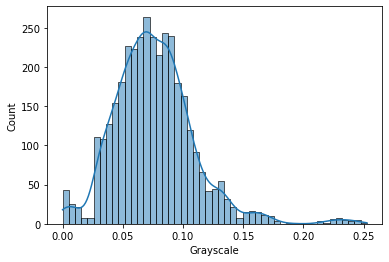

In [277]:
import seaborn as sns
ax = sns.histplot(mattrain[1],  kde=True)
ax.set(xlabel='Color of Grayscale')
plt.show()

Obviously the results are higher.It could be explain by the fact that the features obtain by the grayscale histogram are very few compared with HOG features, so the result doesn't change a lot from which we will obtain with only the latter features. 

### Final result

In [168]:
hog_train_final, hog_test_final = hog_apply(data_train, data_test, (8,8), (4,4), 'L2-Hys')

100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


In [169]:
labels_list = [ 'Non demented', 'Very mild', 'Mild','Moderate']
rep_times = [2562, 1792, 719, 53]
labels = create_labels(labels_list, rep_times)

rep_times_test = [638, 448, 177, 11]
labels_test = create_labels(labels_list, rep_times_test)

In [170]:
X_train = np.vstack((hog_train_final[1],hog_train_final[2],hog_train_final[3],hog_train_final[4]))
X_train_prepared = scalify.fit_transform(X_train)
sgd_clf = SGDClassifier(random_state = 42, alpha = 0.001, loss = 'log_loss', max_iter = 1000, penalty = 'l2', tol = 0.001)
sgd_clf.fit(X_train_prepared, labels)

SGDClassifier(alpha=0.001, loss='log_loss', random_state=42)

In [181]:
X_test = np.vstack((hog_test_final[1], hog_test_final[2], hog_test_final[3], hog_test_final[4]))
X_test_prepared = scalify.fit_transform(X_test)
y_pred = sgd_clf.predict(X_test_prepared)

In [182]:
print(np.array(y_pred == labels_test)[:20])
print('Percentage correct: ', 100*np.sum(y_pred == labels_test)/len(labels_test))

[ True  True  True  True  True  True False  True  True False  True  True
  True  True  True  True  True  True  True  True]
Percentage correct:  70.72213500784929


This is the best result we have achieved.

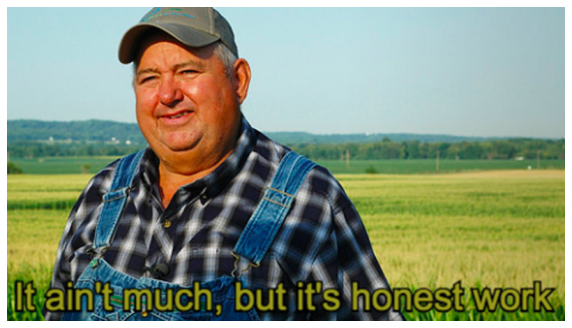

In [101]:
plt.figure(figsize=(10,10))
plt.imshow(mri)
plt.axis('off')
plt.show()

## Evaluete the results

### Confusion matrix

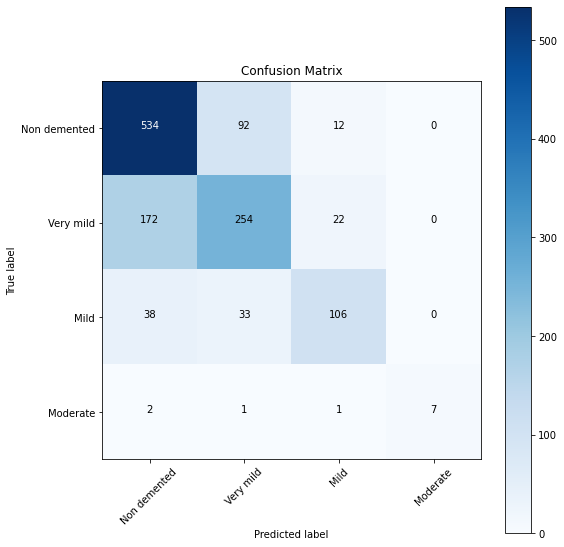

In [195]:
# Import required packages
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

plt.figure(figsize=(8,8))

classes=[ 'Non demented', 'Very mild', 'Mild', 'Moderate']

# Create a confusion matrix
confusion_mat = confusion_matrix(labels_test, y_pred, labels = classes)

# Visualize the confusion matrix using a heatmap
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add labels to the plot
thresh = confusion_mat.max() / 2.
for i, j in itertools.product(range(confusion_mat.shape[0]), range(confusion_mat.shape[1])):
    plt.text(j, i, confusion_mat[i, j], horizontalalignment="center", color="white" if confusion_mat[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Recall and Precision

In [186]:
pred1 = y_pred=='Non demented'
true1 = labels_test=='Non demented'
rec1 = sum(pred1*true1)/sum(true1)

pred2 = y_pred=='Very mild'
true2 = labels_test=='Very mild'
rec2 = sum(pred2*true2)/sum(true2)

pred3 = y_pred=='Mild'
true3 = labels_test=='Mild'
rec3 = sum(pred3*true3)/sum(true3)

pred4 = y_pred=='Moderate'
true4 = labels_test=='Moderate'
rec4 = sum(pred4*true4)/sum(true4)

pred1 = y_pred=='Non demented'
true1 = labels_test=='Non demented'
prec1 = sum(pred1*true1)/sum(pred1)

pred2 = y_pred=='Very mild'
true2 = labels_test=='Very mild'
prec2 = sum(pred2*true2)/sum(pred2)

pred3 = y_pred=='Mild'
true3 = labels_test=='Mild'
prec3 = sum(pred3*true3)/sum(pred3)

pred4 = y_pred=='Moderate'
true4 = labels_test=='Moderate'
prec4 = sum(pred4*true4)/sum(pred4)

In [201]:
recall=[rec1,rec2,rec3,rec4]
precision=[prec1,prec2,prec3,prec4]

In [200]:
result = pd.DataFrame(data = {'RECALL': recall,'PRECISION':precision},index=['Non demented','Very mild demented','Mild demented','Moderate demented'])
print(round(result,2))

                    RECALL  PRECISION
Non demented          0.84       0.72
Very mild demented    0.57       0.67
Mild demented         0.60       0.75
Moderate demented     0.64       1.00


As easy to imagine our model predict better the images belong to the larger folder, non demented patients. It confuses the MRI belong to the very mild e mild more then moderate, it is surprising because the number of moderate test images are very few (only 11) so we thought that our model could be affected by the so called accuracy paradox. Furthermore the moderate images have the maximum precision: if we tried to divide our dataset between more serious and less serious patients, our model would ascertain the latter stage with absolute precision.
Looking at the results we can say that the most difficult stage to predict for our algorithm is the very mild demented:
the medical purpose in this study is understand as soon as possible the illness' presence, for that reason very mild demented MRI are very similar to non demented MRI and our model doesn't manage to predict them.